In [1]:
import random as r
import json

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from AbstractArchitecture_v2 import AbstractArchitecture
from DenseEncoder import DenseEncoder
from DenseDecoder import DenseDecoder
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from plot_model_prediction import plot_model_prediction

In [ ]:
# Set data file locations
data_file_prefix = './data/NLSL_expt1'

# Specify where model weights are saved
mw_path = "./model_weights/NLSL_Experiment_03c_final_model_weights.tf"
l=128

In [2]:
# Step 1. Load in the data
data_train_u = np.load("{}_train1_u.npy".format(data_file_prefix)).astype(np.float32)
data_train_f = np.load("{}_train1_f.npy".format(data_file_prefix)).astype(np.float32)
data_val_u = np.load("{}_val_u.npy".format(data_file_prefix)).astype(np.float32)
data_val_f = np.load("{}_val_f.npy".format(data_file_prefix)).astype(np.float32)
data_test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix)).astype(np.float32)
data_test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix)).astype(np.float32)
data_test_u = np.load("{}_test2_u.npy".format(data_file_prefix)).astype(np.float32)
data_test_f = np.load("{}_test2_f.npy".format(data_file_prefix)).astype(np.float32)

In [5]:
# Reconstruct network:
activation = "relu"
initializer = tf.keras.initializers.VarianceScaling()
reg_lambda_l2 = 1e-6
regularizer = tf.keras.regularizers.l2(reg_lambda_l2)

act_layer = dict(activation=activation,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
lin_layer = dict(activation=None,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
latent_config = dict(activation=None,
                     kernel_regularizer=regularizer,
                     use_bias=False)

encoder_layers = 5
decoder_layers = 5
add_identity = True

# Model training setting
## Set optimizer
optimizer = keras.optimizers.Adam
optimizer_opts = {}

# Callback function(s) and fit method options
cbs = []

############################################
### Everything below here is automated!! ###
############################################


# Step 2. Set up the model architecture
_, n = data_train_u.shape

encoder_config = {'units_full': n,
                  'num_layers': encoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

decoder_config = {'units_full': n,
                  'num_layers': decoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

# Aggregate settings for model architecture
architecture_config = {'units_latent': l,
                       'units_full': n,
                       'u_encoder_block': DenseEncoder(**encoder_config),
                       'u_decoder_block': DenseDecoder(**decoder_config),
                       'F_encoder_block': DenseEncoder(**encoder_config),
                       'F_decoder_block': DenseDecoder(**decoder_config),
                       'latent_config': latent_config}

###############################################
# Step 5. Set up the full architecture run!!
###############################################

# Set up validation data, loss functions, and number of epochs
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f, data_val_u)]
loss_fns = 4*[NMSE()]

# Instantiate the new model
full_model = AbstractArchitecture(**architecture_config,
                                  train_autoencoders_only=False)

# Load the weights
full_model.load_weights(mw_path)
full_model.compile(loss=loss_fns, optimizer=optimizer())

In [12]:
# Set up loss function to evaluate losses
lossfn = NMSE()

# Predict results for all validation data
u_pred, F_pred, Lv_pred, Linvf_pred = full_model.predict([data_val_u, data_val_f])

# Score the results
u_pred_score = lossfn(u_pred, data_val_u)
F_pred_score = lossfn(F_pred, data_val_f)
Lv_pred_score = lossfn(Lv_pred, data_val_f)
Linvf_pred_score = lossfn(Linvf_pred, data_val_u)

In [47]:
# Find best solution for autoencoders
r=tf.norm(Lv_pred-val_F, axis=0)
s=tf.norm(Linvf_pred-val_u,axis=0)

print(np.argmin(s), np.argmin(r))

0 124


In [45]:
# Create plots from a specified validation solution
i = 124

val_u = data_val_u[i,:]
val_F = data_val_f[i,:]

u_pp = u_pred[i,:]
F_pp = F_pred[i,:]
Lv_pp = Lv_pred[i,:]
Linvf_pp = Linvf_pred[i,:]

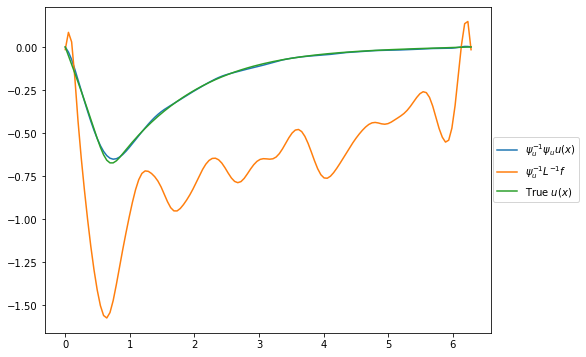

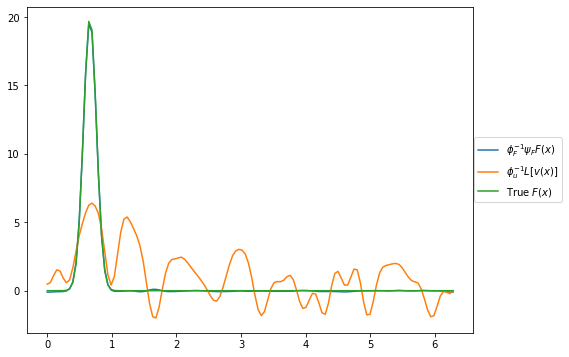

In [46]:
x = np.linspace(0,2*np.pi, 128)

fs = (8,6)
plt.figure(figsize=fs)

plt.plot(x, u_pp, label=r'$\psi^{-1}_u \psi_u u(x)$')
plt.plot(x, Linvf_pp, label=r'$\psi^{-1}_u L^{-1}f$')
plt.plot(x, val_u, label=r'True $u(x)$')
plt.legend(bbox_to_anchor=(1.1,0.5), loc='center')

fs = (8,6)
plt.figure(figsize=fs)

plt.plot(x, F_pp, label=r'$\phi^{-1}_F \psi_F F(x)$')
plt.plot(x, Lv_pp, label=r'$\phi^{-1}_u L[v(x)]$')
plt.plot(x, val_F, label=r'True $F(x)$')
plt.legend(bbox_to_anchor=(1.1,0.5), loc='center')

plt.show()

In [30]:
val_u.shape

(128,)

In [31]:
#v = u_encoder(val_u.reshape(-1,1))
#f = F_encoder(val_F)

InvalidArgumentError: Matrix size-incompatible: In[0]: [128,1], In[1]: [128,128] [Op:MatMul]